# Artist-free Song Recommender
> In this tutorial, we will first fetch the data from Spotify API, then preprocess it and perform EDA. After that we will train a genre predictor model and replace the Spotify's predicted genre with our predicted values. We are doing this replacement because Spotify uses artist's information also in predicting genres but we are building a song recommender that find similar songs purely on the basis of song features because using artist's info adds a fairness bias to the recommendations. Spotify gets higher accuracy but at the cost of fairness to the artists. After building genre classification model, we will train a KNN model, a non-personalized memory-based model, to find top-k similar songs. 

- toc: true
- badges: true
- comments: true
- categories: [Fairness, Music, API, KNN, SHAP, XGBoost]
- image:

## Introduction

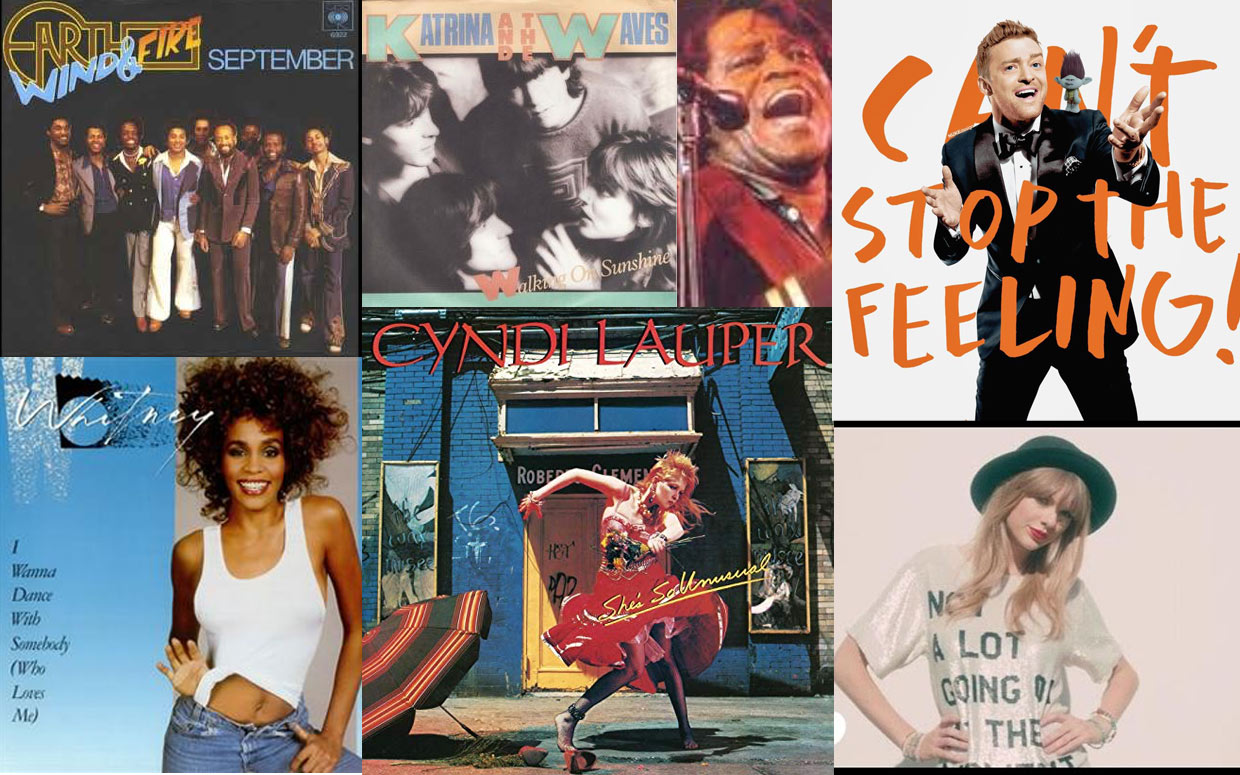

Musicians, often times, have varying styles from album to album and from track to track. They tend to dislike being put in a “genre” box which many organizations tend to do. For example, following his first Grammy win for his album “Igor” in 2020, Tyler the Creator "admitted that while he was "very grateful" for his win, the categorizing of his album as rap was a "backhanded compliment."

Spotify tends to label the genre of songs based off what genre the artist falls under which is quite unfair to an artist if said artist wants to branch out. Not only that, if a user likes just a particular song from an artist, but not every song from said artist, how can one recommend songs based off that particular song without influence from the artists genre? Can we use the predicted genre of a song, as well as other features, to make better song recommendations based off an inputted song?

## Setup

In [ ]:
!pip install shap
!pip install spotipy

In [108]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# import imbalanced pipeline since you can't use SMOTE with the regular python pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

import xgboost
from xgboost import XGBClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

import pickle

import shap

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'svg'

plt.style.use('fivethirtyeight')
plt.style.use('seaborn-notebook')
plt.style.use('default')

In [168]:
!pip install -q watermark
%reload_ext watermark
%watermark -m -iv -u -t -d

Last updated: 2021-07-29 07:42:49

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

IPython   : 5.5.0
xgboost   : 0.90
scipy     : 1.4.1
matplotlib: 3.2.2
shap      : 0.39.0
spotipy   : 2.18.0
seaborn   : 0.11.1
pandas    : 1.1.5
sklearn   : 0.0
numpy     : 1.19.5



## Fetch data from Spotify API

In [44]:
!cp /content/drive/MyDrive/mykeys.py /content
import mykeys
!rm /content/mykeys.py

client_id = mykeys.spotify_client_id
client_secret = mykeys.spotify_client_secret

In [45]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

In [5]:
# to convert keys to values
key_octave_values = ['C', 'C#/Db','D','D#/Eb', 'E',
                    'F', 'F#/Gb', 'G', 'G#/Ab', 'A',
                    'A#/Bb', 'B']

mode_mm_values = ['Minor', 'Major']
explicit_values = ['Clean', 'Explicit']

In [6]:
# static column names to use to build dataframe
column_names = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 
                'track_href', 'analysis_url', 'duration_ms', 'time_signature']

In [7]:
# convert playlists (From a playlist id) to dataframe 
def user_playlist_tracks_full(spotify_connection=sp, user=None, 
                              playlist_id=None, genre=None):

    # first run through also retrieves total no of songs in library
    response = spotify_connection.user_playlist_tracks(user, playlist_id, limit=100)
    results = response["items"]

    # subsequently runs until it hits the user-defined limit or has read all songs in the library
    # spotify limits 100 songs per request so used a while loop to read all songs
    while len(results) < response["total"]:
        response = spotify_connection.user_playlist_tracks(
            user, playlist_id, limit=100, offset=len(results)
        )
        results.extend(response["items"])
    
    #Retrieve song ids
    playlist_song_ids = []
    for each in range(len(results)):
        playlist_song_ids.append((results[each]['track']['id']))
    #Remove possible nones
    playlist_song_ids = [i for i in playlist_song_ids if i]
    
    #Create dataframe
    theDataFrame = pd.DataFrame(columns = column_names)
    #Add features
    while(len(playlist_song_ids)>0):
        theDataFrame = theDataFrame.append(sp.audio_features(playlist_song_ids[:100]),ignore_index=True)
        playlist_song_ids = playlist_song_ids[100:]
    
    #Pass in genre dependent on name of playlist
    theDataFrame['genre'] = genre

    return theDataFrame

In [9]:
# retrieving data for 4 genres from their respective playlists
alt_metal_songs = user_playlist_tracks_full(playlist_id = '40DeXsA9tEIwNwBmrZ4rkt', genre = 'alt-metal')
hiphop_songs = user_playlist_tracks_full(playlist_id = '13u9Bn677jEHePtS7XKmih', genre = 'hip-hop')
rock_songs = user_playlist_tracks_full(playlist_id = '1SY54UtMrIadoVThZsJShG', genre = 'rock')
pop_songs = user_playlist_tracks_full(playlist_id = '1szFiylNjSI99tpQgVZ3ki', genre = 'pop')

# combine the dataframes
all_songs = hiphop_songs.append([pop_songs, rock_songs, alt_metal_songs], ignore_index=True)

# to make sure the number of records are same
assert len(all_songs) == len(alt_metal_songs) + len(hiphop_songs) + len(rock_songs) + len(pop_songs)

# printing number of records of each genre
len(alt_metal_songs), len(hiphop_songs), len(rock_songs), len(pop_songs)

(1285, 2189, 1084, 710)

In [10]:
all_songs.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre
0,0.507,0.985,0,-2.392,1,0.1530,0.22800,0.000033,0.190,0.394,150.059,audio_features,7hQ0ojbeqicGhw0wdUVeaN,spotify:track:7hQ0ojbeqicGhw0wdUVeaN,https://api.spotify.com/v1/tracks/7hQ0ojbeqicG...,https://api.spotify.com/v1/audio-analysis/7hQ0...,139560,4,hip-hop
1,0.625,0.726,10,-7.731,0,0.1550,0.00728,0.000000,0.318,0.483,103.980,audio_features,6C7RJEIUDqKkJRZVWdkfkH,spotify:track:6C7RJEIUDqKkJRZVWdkfkH,https://api.spotify.com/v1/tracks/6C7RJEIUDqKk...,https://api.spotify.com/v1/audio-analysis/6C7R...,311867,4,hip-hop
2,0.552,0.846,9,-4.912,1,0.3420,0.01140,0.000000,0.309,0.554,98.560,audio_features,2dxjKgT0li4qBI3QwuN9Ih,spotify:track:2dxjKgT0li4qBI3QwuN9Ih,https://api.spotify.com/v1/tracks/2dxjKgT0li4q...,https://api.spotify.com/v1/audio-analysis/2dxj...,236600,1,hip-hop
3,0.685,0.631,7,-10.338,1,0.0926,0.02490,0.000077,0.211,0.720,104.126,audio_features,4oNM6CscdoUZDHvzl18nbt,spotify:track:4oNM6CscdoUZDHvzl18nbt,https://api.spotify.com/v1/tracks/4oNM6CscdoUZ...,https://api.spotify.com/v1/audio-analysis/4oNM...,293493,4,hip-hop
4,0.640,0.864,4,-4.909,0,0.0869,0.04090,0.000002,0.136,0.497,105.107,audio_features,6XGddj522FQRHXEhBtjiJu,spotify:track:6XGddj522FQRHXEhBtjiJu,https://api.spotify.com/v1/tracks/6XGddj522FQR...,https://api.spotify.com/v1/audio-analysis/6XGd...,272667,4,hip-hop


## EDA

In [11]:
all_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      5268 non-null   float64
 1   energy            5268 non-null   float64
 2   key               5268 non-null   object 
 3   loudness          5268 non-null   float64
 4   mode              5268 non-null   object 
 5   speechiness       5268 non-null   float64
 6   acousticness      5268 non-null   float64
 7   instrumentalness  5268 non-null   float64
 8   liveness          5268 non-null   float64
 9   valence           5268 non-null   float64
 10  tempo             5268 non-null   float64
 11  type              5268 non-null   object 
 12  id                5268 non-null   object 
 13  uri               5268 non-null   object 
 14  track_href        5268 non-null   object 
 15  analysis_url      5268 non-null   object 
 16  duration_ms       5268 non-null   object 


In [14]:
# drop unneccessary attributes
all_songs.drop(['type', 'uri', 'track_href', 'analysis_url'], axis = 1, inplace = True)

# convert from object to float
all_songs['duration_ms'] = all_songs['duration_ms'].astype(float)

In [16]:
all_songs.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
danceability,5268,NaN,NaN,NaN,0.570262,0.180178,0,0.44075,0.571,0.711,0.966
energy,5268,NaN,NaN,NaN,0.705046,0.198815,2.02e-05,0.583,0.733,0.863,0.999
key,5268,12,1,683,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loudness,5268,NaN,NaN,NaN,-7.17693,3.37105,-35.553,-8.70725,-6.51,-4.935,-0.839
mode,5268,2,1,3223,NaN,NaN,NaN,NaN,NaN,NaN,NaN
speechiness,5268,NaN,NaN,NaN,0.14527,0.14655,0,0.0416,0.0787,0.22,0.966
acousticness,5268,NaN,NaN,NaN,0.161367,0.232402,1.2e-06,0.0031075,0.04845,0.228,0.996
instrumentalness,5268,NaN,NaN,NaN,0.0935435,0.226144,0,0,4.92e-05,0.01635,0.998
liveness,5268,NaN,NaN,NaN,0.2443,0.214532,0,0.102,0.154,0.321,0.996
valence,5268,NaN,NaN,NaN,0.463612,0.239109,0,0.277,0.449,0.647,0.989


In [17]:
all_songs.query("danceability == 0")

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,genre
297,0.0,0.3030,4,-22.355,1,0.0,0.970,0.000000,0.617,0.0,0.0,49cwtNGrl6Zr28VnoeJp9P,13400.0,0,hip-hop
612,0.0,0.3030,4,-22.355,1,0.0,0.970,0.000000,0.617,0.0,0.0,3izxuGg0shtMWtx34YeIAl,13400.0,0,hip-hop
704,0.0,0.2160,6,-17.465,1,0.0,0.570,0.000000,0.143,0.0,0.0,0gf3RV9uNeiXgII9bBj3uU,11187.0,0,hip-hop
708,0.0,0.2530,0,-16.671,1,0.0,0.603,0.000000,0.126,0.0,0.0,1HNNuNdS3TGXayZ85NujZ7,8120.0,0,hip-hop
712,0.0,0.1730,6,-18.560,1,0.0,0.385,0.000004,0.000,0.0,0.0,3DO3XiJr2RQqDjeTUkThI9,7173.0,0,hip-hop
2975,0.0,0.0613,9,-22.937,1,0.0,0.318,0.000000,0.317,0.0,0.0,7rNv06qGP8OwY49hw06V0p,13853.0,0,rock
4197,0.0,0.4730,1,-16.139,1,0.0,0.485,0.000004,0.683,0.0,0.0,4ymIihKTFmk3s0wrgud1kU,81800.0,0,alt-metal
4721,0.0,0.1160,0,-26.914,1,0.0,0.989,0.000000,0.248,0.0,0.0,1CSGZRbxGVY4zXbEEZcHsP,8293.0,0,alt-metal


In [18]:
def song_artist_from_key(sp,key):
    theTrack = sp.track(key)
    if(theTrack is not None):
        song_title = theTrack['name']
        artist_title = theTrack['artists'][0]['name']
        song_link = theTrack['external_urls']['spotify']
        return (song_title, artist_title, song_link)
    else:
        return None

In [19]:
zero_dance_list = all_songs.query("danceability == 0")['id']
for each in zero_dance_list:
    print(song_artist_from_key(sp,each))

('Factory Girl (Skit)', 'G-Eazy', 'https://open.spotify.com/track/49cwtNGrl6Zr28VnoeJp9P')
('Factory Girl (Skit)', 'G-Eazy', 'https://open.spotify.com/track/3izxuGg0shtMWtx34YeIAl')
('Jeselnik Skit 3', 'Your Old Droog', 'https://open.spotify.com/track/0gf3RV9uNeiXgII9bBj3uU')
('Jeselnik Skit 2', 'Your Old Droog', 'https://open.spotify.com/track/1HNNuNdS3TGXayZ85NujZ7')
('Jeselnik Skit 1', 'Your Old Droog', 'https://open.spotify.com/track/3DO3XiJr2RQqDjeTUkThI9')
('Ringo? Yep! - Live At The BBC For "From Us To You Say The Beatles" / 30th March, 1964', 'The Beatles', 'https://open.spotify.com/track/7rNv06qGP8OwY49hw06V0p')
('Prelude (The Family Trip)', 'Marilyn Manson', 'https://open.spotify.com/track/4ymIihKTFmk3s0wrgud1kU')
('Grasshopper', 'Sevendust', 'https://open.spotify.com/track/1CSGZRbxGVY4zXbEEZcHsP')


In [20]:
zero_tempo_list = all_songs.query("tempo == 0")['id']
for each in zero_tempo_list:
    print(song_artist_from_key(sp,each))

('Factory Girl (Skit)', 'G-Eazy', 'https://open.spotify.com/track/49cwtNGrl6Zr28VnoeJp9P')
('Factory Girl (Skit)', 'G-Eazy', 'https://open.spotify.com/track/3izxuGg0shtMWtx34YeIAl')
('Jeselnik Skit 3', 'Your Old Droog', 'https://open.spotify.com/track/0gf3RV9uNeiXgII9bBj3uU')
('Jeselnik Skit 2', 'Your Old Droog', 'https://open.spotify.com/track/1HNNuNdS3TGXayZ85NujZ7')
('Jeselnik Skit 1', 'Your Old Droog', 'https://open.spotify.com/track/3DO3XiJr2RQqDjeTUkThI9')
('Ringo? Yep! - Live At The BBC For "From Us To You Say The Beatles" / 30th March, 1964', 'The Beatles', 'https://open.spotify.com/track/7rNv06qGP8OwY49hw06V0p')
('Prelude (The Family Trip)', 'Marilyn Manson', 'https://open.spotify.com/track/4ymIihKTFmk3s0wrgud1kU')
('Grasshopper', 'Sevendust', 'https://open.spotify.com/track/1CSGZRbxGVY4zXbEEZcHsP')


In [21]:
all_songs = all_songs.query("danceability != 0")
all_songs = all_songs.query(f"duration_ms < {1e6}")

In [26]:
def mean_by_genre_plot(ax, groupby, feature):
    sns.barplot(x = all_songs.groupby('genre')[feature].mean().index,
                y = all_songs.groupby('genre')[feature].mean().values,
                ax = ax,)
    ax.set_title(f'Average {feature.title()} by Genre')
    ax.set_ylabel(f'{feature}')
    return ax

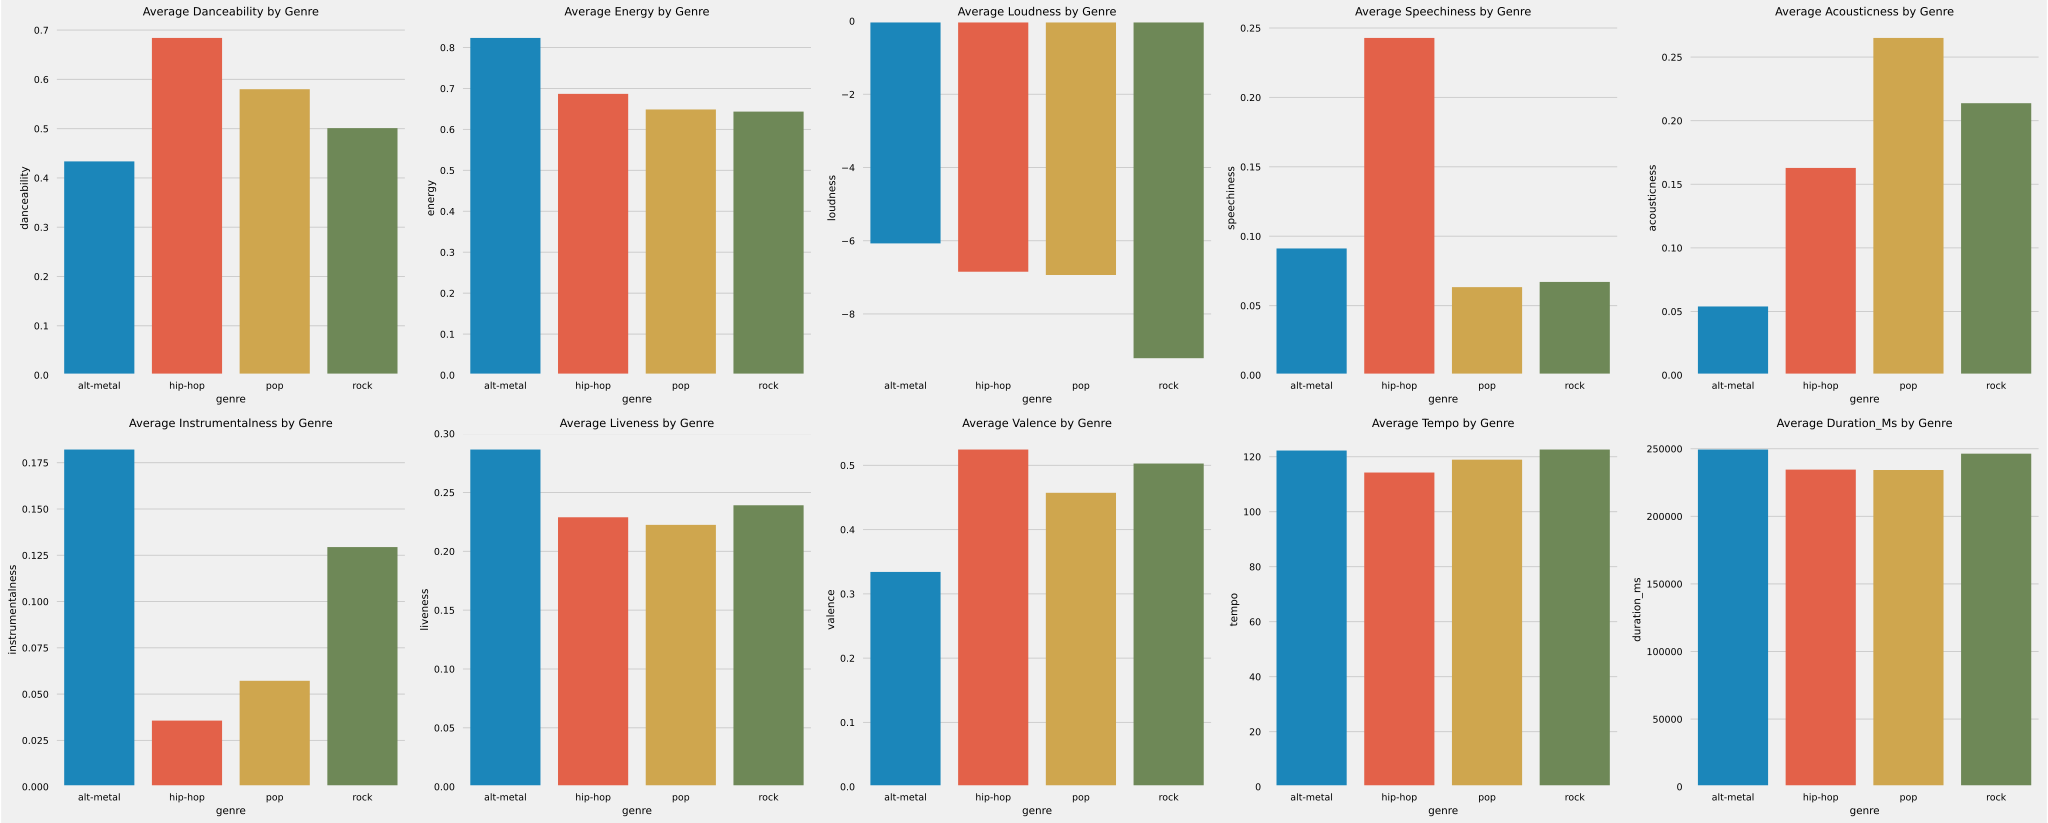

In [61]:
genre_group = all_songs.groupby('genre')
continuous_features = list(all_songs.select_dtypes(include = [float, int]).columns)

# for i, each in enumerate(continuous_features):
#     mean_by_genre_plot(genre_group, each)

fig, ax = plt.subplots(2, 5, figsize=(30,12), constrained_layout=True)

# for i in range(3):
#     for j in range(3):
#         col_name = n_cols[i*3+j]
#         ax[i,j] = plot(data[col_name])

for i, each in enumerate(continuous_features):
    n = 5
    try:
        _ax = ax[i//n,i%n]
        ax[i//n,i%n] = mean_by_genre_plot(_ax, genre_group, each)
    except:
        pass

plt.show()

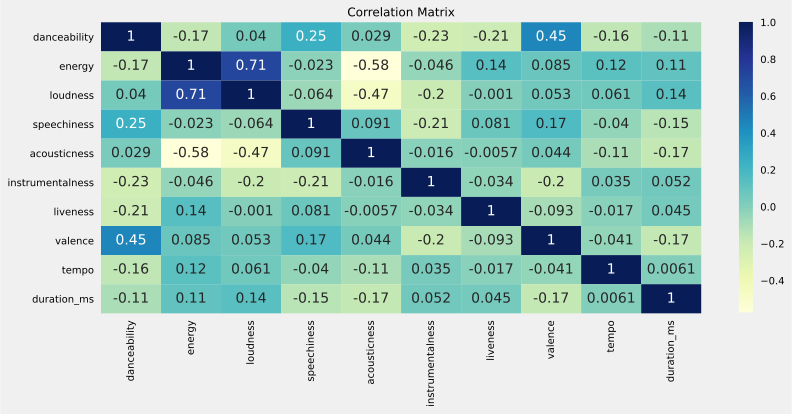

In [62]:
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(all_songs.corr(), annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.show()

In [65]:
all_songs.to_parquet('songs_data.parquet.gzip', compression='gzip')

## Genre Classification Model

In [109]:
df = pd.read_parquet('songs_data.parquet.gzip')
df.set_index('id', inplace=True)
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre
id,,,,,,,,,,,,,,
7hQ0ojbeqicGhw0wdUVeaN,0.507,0.985,0,-2.392,1,0.1530,0.22800,0.000033,0.190,0.394,150.059,139560.0,4,hip-hop
6C7RJEIUDqKkJRZVWdkfkH,0.625,0.726,10,-7.731,0,0.1550,0.00728,0.000000,0.318,0.483,103.980,311867.0,4,hip-hop
2dxjKgT0li4qBI3QwuN9Ih,0.552,0.846,9,-4.912,1,0.3420,0.01140,0.000000,0.309,0.554,98.560,236600.0,1,hip-hop
4oNM6CscdoUZDHvzl18nbt,0.685,0.631,7,-10.338,1,0.0926,0.02490,0.000077,0.211,0.720,104.126,293493.0,4,hip-hop
6XGddj522FQRHXEhBtjiJu,0.640,0.864,4,-4.909,0,0.0869,0.04090,0.000002,0.136,0.497,105.107,272667.0,4,hip-hop


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5257 entries, 7hQ0ojbeqicGhw0wdUVeaN to 0wsj5fPXvVXYjcRJYXNkEl
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      5257 non-null   float64
 1   energy            5257 non-null   float64
 2   key               5257 non-null   int64  
 3   loudness          5257 non-null   float64
 4   mode              5257 non-null   int64  
 5   speechiness       5257 non-null   float64
 6   acousticness      5257 non-null   float64
 7   instrumentalness  5257 non-null   float64
 8   liveness          5257 non-null   float64
 9   valence           5257 non-null   float64
 10  tempo             5257 non-null   float64
 11  duration_ms       5257 non-null   float64
 12  time_signature    5257 non-null   int64  
 13  genre             5257 non-null   object 
dtypes: float64(10), int64(3), object(1)
memory usage: 616.1+ KB


In [111]:
cat_cols = ['key','mode','time_signature']
df[cat_cols] = df[cat_cols].astype('str')

In [112]:
# drop duplicates
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)
print(df.duplicated().sum())

94
0


In [113]:
# split the columns to easily use later
categorical_columns = list(df.drop('genre', axis = 1).select_dtypes('object').columns)
numerical_columns = list(df.drop('genre', axis = 1).select_dtypes(exclude = 'object').columns)

# train test split 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['genre'], axis=1),
                                                    df.genre,
                                                    random_state=42)

# see the percentage of each genre in the whole set
print(y_train.value_counts(normalize=True))

hip-hop      0.411415
alt-metal    0.237862
rock         0.211260
pop          0.139463
Name: genre, dtype: float64


In [114]:
# function to easily view results
def evaluation_report(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"F1 Score: {f1_score(y_test, model.predict(X_test), average = 'macro')}")
    plot_confusion_matrix(model, X_test, y_test, cmap='GnBu',xticks_rotation='vertical',
                          values_format = '')

### First Simple Model
Give us a base model to compare future models to.

In [115]:
lr = LogisticRegression(random_state=42)
ss = StandardScaler()
lr.fit(ss.fit_transform(X_train), y_train)
print(lr.classes_)

['alt-metal' 'hip-hop' 'pop' 'rock']


Training
F1 Score: 0.6354642598446443


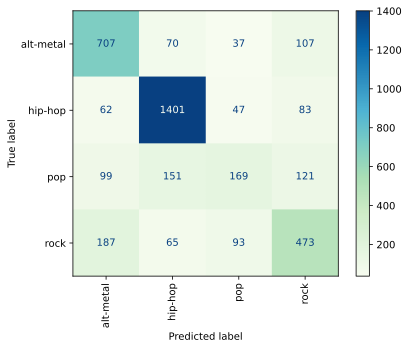

In [116]:
print('Training')
evaluation_report(lr, ss.fit_transform(X_train), y_train)

Testing
F1 Score: 0.6317408538198646


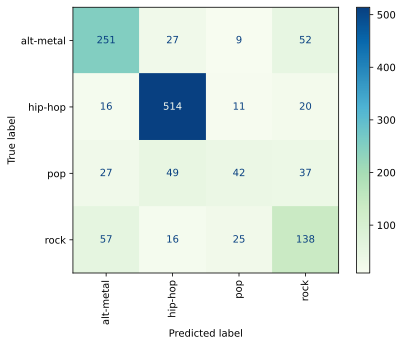

In [117]:
print('Testing')
evaluation_report(lr, ss.transform(X_test), y_test)

### Second Model

- Column transform categorical and numerical
- Address the class imbalance through a balanced class weight
- And lets grid search for best params

In [118]:
# create pipelines for preprocessing. One for numerical data, one for categorical data and a column transformer to do both.
numerical_pipeline = imbpipeline(verbose=False,steps=[
                                ('ss', StandardScaler())
                            ])

categorical_pipeline = imbpipeline(verbose=False,steps=[
                            ('ohe', OneHotEncoder(drop='first',
                                                 sparse=False,))
                            ])

col_trans = ColumnTransformer(verbose=False,transformers=[
    ('numerical', numerical_pipeline, numerical_columns),
    ('categorical', categorical_pipeline, categorical_columns)
])

col_ohe_solo = ColumnTransformer(verbose=False,transformers=[
    ('categorical', categorical_pipeline, categorical_columns)
])

In [119]:
pipe_log = imbpipeline(verbose=False, steps=[
    ('col_trans', col_trans),
    ('lr', LogisticRegression(max_iter = 10000, random_state=9, class_weight='balanced'))
])

param_grid = [
    {
     'lr__penalty' : ['l1','l2'],
     'lr__C' : [.75,.5,.25],
     'lr__solver' : ['saga','sag', 'lbfgs']
    }, 
]

gs_lr = GridSearchCV(pipe_log, param_grid = param_grid, 
                        scoring = 'f1_macro', n_jobs=-1, verbose=True)
gs_lr.fit(X_train, y_train)

gs_lr.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   21.6s finished


{'lr__C': 0.5, 'lr__penalty': 'l1', 'lr__solver': 'saga'}

Training
F1 Score: 0.6529225724434327


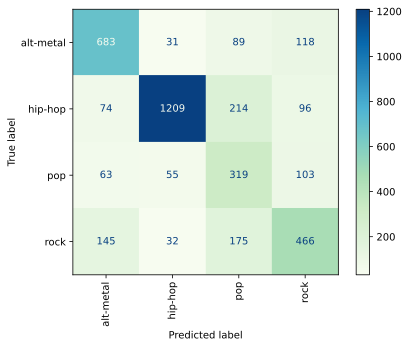

In [120]:
print('Training')
evaluation_report(gs_lr, X_train, y_train)

Testing
F1 Score: 0.6413027113425918


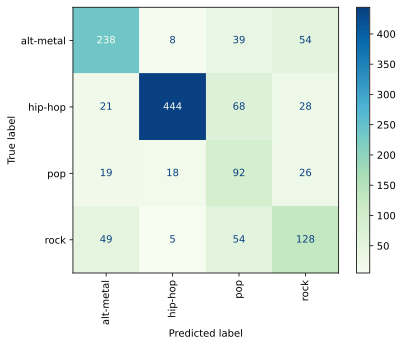

In [121]:
print('Testing')
evaluation_report(gs_lr, X_test, y_test)

### Model 3

Since we have a mixture of categorical and numerical features and a large amount of training samples, lets try XGBoost. Combine that with one hot encoder, smote, and gridsearch and let us see what happens.

In [122]:
ohe = OneHotEncoder(drop='first', sparse=False)
sm = SMOTE(random_state = 42)

train_ohe = ohe.fit_transform(X_train[categorical_columns])
test_ohe = ohe.transform(X_test[categorical_columns])

train_ohe = X_train[numerical_columns].reset_index().join(pd.DataFrame(train_ohe)).set_index('id')

train_sm = sm.fit_resample(train_ohe, y_train)
test_ohe = X_test[numerical_columns].reset_index().join(pd.DataFrame(test_ohe)).set_index('id')

In [124]:
# make sure not to over fit
xgbc = XGBClassifier(random_state = 9, n_jobs = -1)
params = {
    'learning_rate': [.1,.01,.005],
    'n_estimators': range(180,200,20),
    'booster': ['gbtree', 'dart']
}

# run gridsearch
gs_xgbc = GridSearchCV(xgbc, param_grid=params, scoring='f1_macro', n_jobs =-1)

gs_xgbc.fit(train_sm[0], train_sm[1])

gs_xgbc.best_params_

{'booster': 'gbtree', 'learning_rate': 0.1, 'n_estimators': 180}

Training
F1 Score: 0.8309994845008393


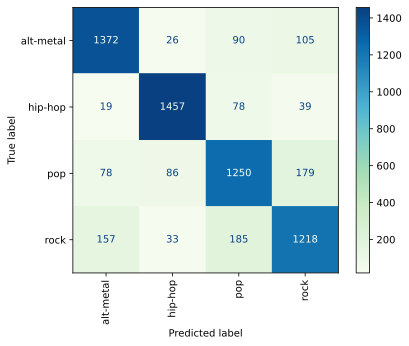

In [125]:
print('Training')
evaluation_report(gs_xgbc, train_sm[0], train_sm[1])

### Model 4

Let's try Random forest classifier

In [126]:
rf = RandomForestClassifier(n_jobs = -1, random_state = 9, class_weight = 'balanced')

params = {
    'max_depth': [6,7],
    'n_estimators': [197,198,199,300],
    'criterion': ['gini', 'entropy'],
}

#Run gridsearch
gs_rf = GridSearchCV(rf, param_grid=params, scoring='f1_macro', n_jobs =-1 )
gs_rf.fit(train_ohe, y_train)

gs_rf.best_params_

{'criterion': 'gini', 'max_depth': 7, 'n_estimators': 300}

Training
F1 Score: 0.7602740286139543


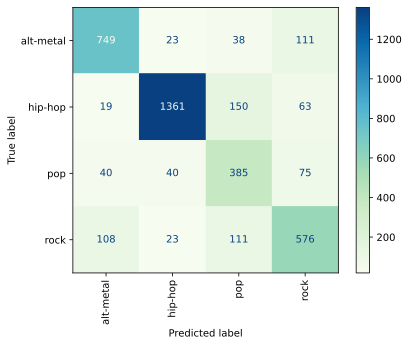

In [127]:
print('Training')
evaluation_report(gs_rf, train_ohe, y_train)

Testing
F1 Score: 0.6664989980115177


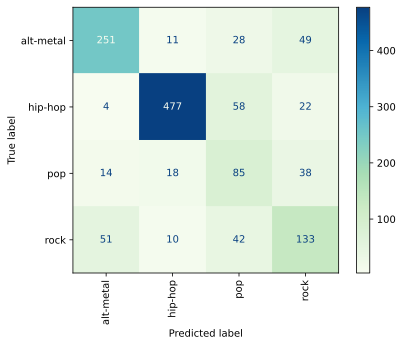

In [128]:
print('Testing')
evaluation_report(gs_rf, test_ohe, y_test)

### Model 5

Voting classifier

In [129]:
voting_clf = VotingClassifier(
                estimators=[('xgb', gs_xgbc.best_estimator_),
                             ('rf', gs_rf.best_estimator_)], 
                voting='hard')

voting_clf.fit(train_ohe, y_train);

Training
F1 Score: 0.7836249599867496


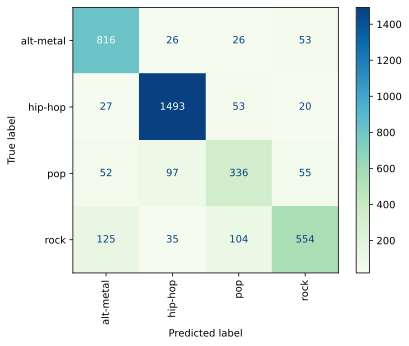

In [130]:
print("Training")
evaluation_report(voting_clf, train_ohe, y_train)

Testing
F1 Score: 0.6757928181347662


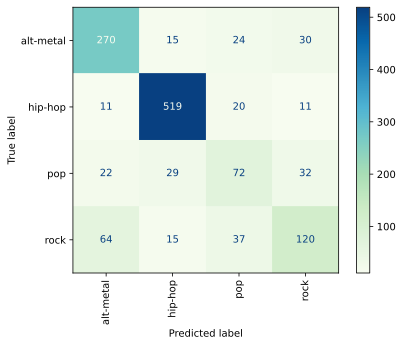

In [131]:
print("Testing")
evaluation_report(voting_clf, test_ohe, y_test)

### Best Model

F1 Score: 0.7659231295422055


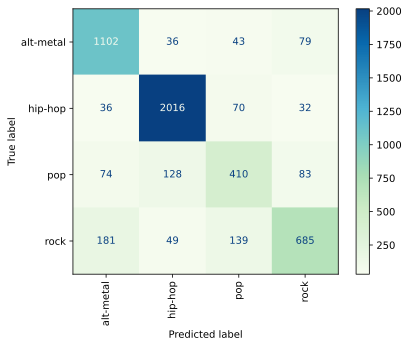

In [132]:
best_model = voting_clf

X_final = df.drop('genre', axis = 1)
y_final = df.genre

# follow the same transformation on the initial model and do the same to whole dataframe
final_ohe = ohe.transform(X_final[categorical_columns])
final_ohe = X_final[numerical_columns].reset_index().join(pd.DataFrame(final_ohe)).set_index('id')

# fit best model on whole dataset
best_model.fit(final_ohe, y_final)

# See how well it does
evaluation_report(best_model, final_ohe, y_final)

### Model Analysis
See which features are most important in predicting genre

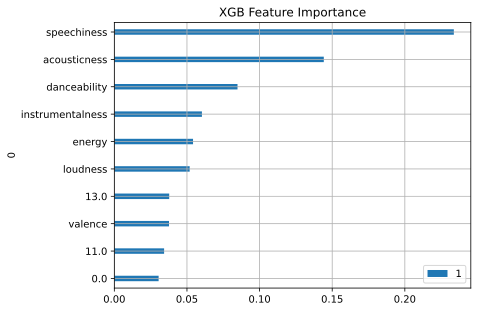

In [133]:
vclf_xgbc = best_model.estimators_[0]

# plot feature importance from gradient boosting classifier
pd.DataFrame([final_ohe.columns,vclf_xgbc.feature_importances_]).T.set_index(0).sort_values(by=1, ascending = False)[:10].sort_values(by=1, ascending = True)\
.plot(kind="barh", width=.2, grid=True, title = "XGB Feature Importance");

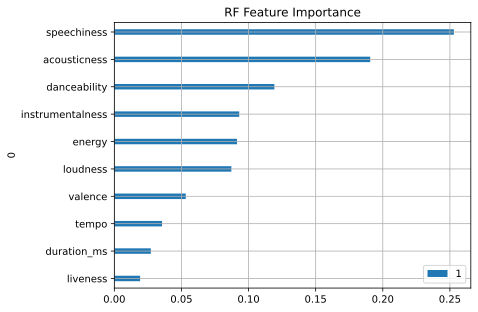

In [134]:
vclf_rf = best_model.estimators_[1]

# plot feature importance from random forest classifier
pd.DataFrame([final_ohe.columns,vclf_rf.feature_importances_]).T.set_index(0).sort_values(by=1, ascending = False)[:10].sort_values(by=1, ascending = True)\
.plot(kind="barh", width=.2, grid=True, title = "RF Feature Importance");

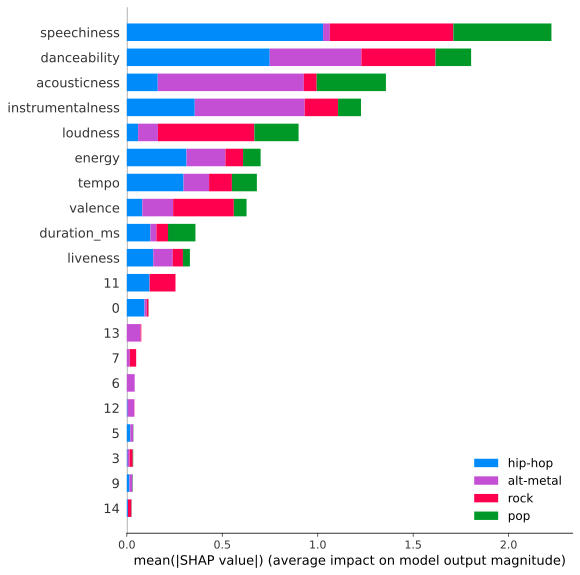

In [135]:
explainer = shap.TreeExplainer(vclf_xgbc)
shap_values = explainer.shap_values(final_ohe)
shap.summary_plot(shap_values, features=final_ohe, 
                  feature_names=final_ohe.columns, 
                  class_names = voting_clf.classes_,
                  title = "XGBC Feature Importance")

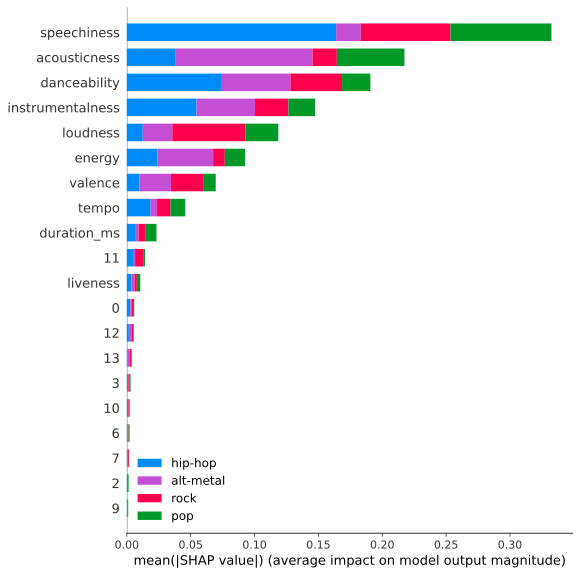

In [136]:
explainer = shap.TreeExplainer(vclf_rf)
shap_values = explainer.shap_values(final_ohe)
shap.summary_plot(shap_values, features=final_ohe, 
                  feature_names=final_ohe.columns, 
                  class_names = voting_clf.classes_)

### Save the results

In [148]:
# modify the dataset with the results
all_songs = df.copy()
all_songs['predicted_genre'] = best_model.predict(final_ohe)
all_songs.drop(['genre'], axis = 1, inplace = True)

# export the data
all_songs.to_parquet('songs_data_processed.parquet.gzip', compression='gzip')

# export the model
with open('genre_predictor.pkl', 'wb') as model_file:
  pickle.dump(best_model, model_file)

# export the OHE encoder
with open('ohe_encoder.pkl', 'wb') as encoder_file:
  pickle.dump(ohe, encoder_file)

## Recommendation Model

A KNN-based non-personalized recommender

### Util functions

In [163]:
# Convert a song_id to a dataframe row
def song_to_df (sp, key):
    cat_cols = ['key', 'mode', 'time_signature']
    num_cols = ['danceability','energy','loudness','speechiness','acousticness',
                'instrumentalness','liveness','valence','tempo','duration_ms']
    
    row = pd.DataFrame(sp.audio_features(key)).drop(['type','uri',
                                               'track_href','analysis_url'], axis=1).set_index('id')
    row[cat_cols] = row[cat_cols].astype('str')
    return row

# Do preprocessing and make a genre prediction for a song 
def make_genre_prediction(sp, key, ohe, model):
    cat_cols = ['key', 'mode', 'time_signature']
    num_cols = ['danceability','energy','loudness','speechiness','acousticness',
                'instrumentalness','liveness','valence','tempo','duration_ms']
    row = song_to_df(sp,key)
    temp_ohe = ohe.transform(row[cat_cols])
    returning_obj = row[num_cols].reset_index().join(pd.DataFrame(temp_ohe)).set_index('id')
    return model.predict(returning_obj)

# Get the song info from song_id
def song_artist_from_key(sp,key):
    theTrack = sp.track(key)
    song_title = theTrack['name']
    artist_title = theTrack['artists'][0]['name']
    song_link = theTrack['external_urls']['spotify']
    return (song_title, artist_title, song_link)

# Get the song id from a query
def song_id_from_query(sp, query):
    q = query
    if(sp.search(q, limit=1, offset=0, type='track')['tracks']['total']>0):
        return sp.search( q, limit=1, offset=0, type='track')['tracks']['items'][0]['id']
    else:
        return None

### Load the artifacts

In [149]:
# import the data
all_songs = pd.read_parquet('songs_data_processed.parquet.gzip')

# import the encoder
with open('ohe_encoder.pkl', 'rb') as encoder_file:
  ohe_make_genre_pred = pickle.load(encoder_file)

# import the model
with open('genre_predictor.pkl', 'rb') as model_file:
  best_model = pickle.load(model_file)

In [141]:
all_songs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5163 entries, 7hQ0ojbeqicGhw0wdUVeaN to 0wsj5fPXvVXYjcRJYXNkEl
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      5163 non-null   float64
 1   energy            5163 non-null   float64
 2   key               5163 non-null   object 
 3   loudness          5163 non-null   float64
 4   mode              5163 non-null   object 
 5   speechiness       5163 non-null   float64
 6   acousticness      5163 non-null   float64
 7   instrumentalness  5163 non-null   float64
 8   liveness          5163 non-null   float64
 9   valence           5163 non-null   float64
 10  tempo             5163 non-null   float64
 11  duration_ms       5163 non-null   float64
 12  time_signature    5163 non-null   object 
 13  predicted_genre   5163 non-null   object 
dtypes: float64(10), object(4)
memory usage: 765.0+ KB


In [150]:
# create variables to easily access categorical and numerical columns
categorical_columns = list(all_songs.select_dtypes('object').columns)
numerical_columns = list(all_songs.select_dtypes(exclude = 'object').columns)
categorical_columns

['key', 'mode', 'time_signature', 'predicted_genre']

In [151]:
all_songs.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,predicted_genre
id,,,,,,,,,,,,,,
7hQ0ojbeqicGhw0wdUVeaN,0.507,0.985,0,-2.392,1,0.1530,0.22800,0.000033,0.190,0.394,150.059,139560.0,4,alt-metal
6C7RJEIUDqKkJRZVWdkfkH,0.625,0.726,10,-7.731,0,0.1550,0.00728,0.000000,0.318,0.483,103.980,311867.0,4,hip-hop
2dxjKgT0li4qBI3QwuN9Ih,0.552,0.846,9,-4.912,1,0.3420,0.01140,0.000000,0.309,0.554,98.560,236600.0,1,hip-hop
4oNM6CscdoUZDHvzl18nbt,0.685,0.631,7,-10.338,1,0.0926,0.02490,0.000077,0.211,0.720,104.126,293493.0,4,hip-hop
6XGddj522FQRHXEhBtjiJu,0.640,0.864,4,-4.909,0,0.0869,0.04090,0.000002,0.136,0.497,105.107,272667.0,4,hip-hop


### KNN Model

In [152]:
# create a nearest neighbors object using cosine similarity metric.
neigh = NearestNeighbors(n_neighbors=15, radius=0.45, metric='cosine')

X_knn = all_songs

# total dataframe normalizing for nearest neighbors
MMScaler = preprocessing.MinMaxScaler()
MinMaxScaler = preprocessing.MinMaxScaler()
X_knn[numerical_columns] = MinMaxScaler.fit_transform(X_knn[numerical_columns])

# total dataframe dummying
ohe_knn = OneHotEncoder(drop='first', sparse=False)
X_knn_ohe = ohe_knn.fit_transform(X_knn[categorical_columns])
X_knn_transformed = X_knn[numerical_columns].reset_index().join(pd.DataFrame(X_knn_ohe, columns = ohe_knn.get_feature_names(categorical_columns))).set_index('id')

# fit the model
neigh.fit(X_knn_transformed)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                 radius=0.45)

In [153]:
# preprocessing for a single song
def knn_preprocessing(sp, key, num_col = numerical_columns, 
                      cat_col = categorical_columns,
                      mmScaler = MinMaxScaler, bm = best_model,
                      ohe_knn = ohe_knn, ohe_make_genre_pred = ohe_make_genre_pred):
    # Convert song to the dataframe
    row = song_to_df(sp, key)
    # Make genre prediction for inputted song
    genre = make_genre_prediction(sp,key, ohe_make_genre_pred, bm)
    # Append the predicted genre
    row['predicted_genre'] = genre[0]
    # Dummy the categorical
    row_dummied = ohe_knn.transform(row[cat_col])
    # Normalize the numerical
    row[num_col] = mmScaler.transform(row[num_col])
    # Combine the preprocessed rows and return it
    row = row[num_col].reset_index().join(pd.DataFrame(row_dummied, columns = ohe_knn.get_feature_names(cat_col))).set_index('id')
    return row

In [154]:
def make_song_recommendations(sp, kneighs, query):
    #If the query is aspace or not filled, return no results
    if(query.isspace() or not query):
        return "No results found"
    song_id = song_id_from_query(sp, query)
    # If the query doesn't return an id, return no results
    if(song_id == None):
        return "No results found"
    # Get the song info
    song_plus_artist = song_artist_from_key(sp, song_id)
    # Preprocess the tracks
    song_to_rec = knn_preprocessing(sp, song_id)
    # Get the 15 nearest neighbors to inputted song
    nbrs = neigh.kneighbors(
       song_to_rec, 15, return_distance=False
    )
    # Properly retrieve the song info of each neighbor and return it
    playlist = []
    for each in nbrs[0]:
        the_rec_song = song_artist_from_key(sp, X_knn_transformed.iloc[each].name)
        if (((the_rec_song[0:2]) != song_plus_artist[0:2]) and
           ((the_rec_song[0:2]) not in playlist)):
            playlist.append(song_artist_from_key(sp, X_knn_transformed.iloc[each].name))
    return (playlist)

### Recommendations

In [155]:
# knowledge check to see if it matches
song_artist_from_key(sp, '6XGddj522FQRHXEhBtjiJu')

('Strobelite (feat. Peven Everett)',
 'Gorillaz',
 'https://open.spotify.com/track/6XGddj522FQRHXEhBtjiJu')

In [156]:
# get the ID from query
song_id_from_query(sp, "strobelite")

'6XGddj522FQRHXEhBtjiJu'

In [166]:
# make the genre prediction
make_genre_prediction(sp, '6XGddj522FQRHXEhBtjiJu', ohe_make_genre_pred, best_model)[0]

'hip-hop'

In [167]:
# make the song recommendations
make_song_recommendations(sp, neigh, "strobelite")

[('Peace of What',
  'RJD2',
  'https://open.spotify.com/track/2o2KHNSVo9VNwMTZkKqHMb'),
 ("Beggin'",
  'Madcon',
  'https://open.spotify.com/track/2BP35fcV8ASc2JK6XlkW0O'),
 ('Knock Knock',
  'Mac Miller',
  'https://open.spotify.com/track/3uYm4MtU6jUQft2DtGqEoZ'),
 ('If Time Is Money (Fly Navigation) [feat. Method Man]',
  'Wu-Tang Clan',
  'https://open.spotify.com/track/2yZp0a4buLcNHCw4NAjwqh'),
 ('Puke', 'Eminem', 'https://open.spotify.com/track/5F94xbz85nE6wfZGHqOMCG'),
 ('Superman',
  'Eminem',
  'https://open.spotify.com/track/4woTEX1wYOTGDqNXuavlRC'),
 ('Wonda Why They Call U B____',
  '2Pac',
  'https://open.spotify.com/track/47lnB0fWXHnI5CBMx0OXB3'),
 ('Shorty Wanna Be A Thug',
  '2Pac',
  'https://open.spotify.com/track/4L1aB9H3HGsVstHlOM6Yz6'),
 ("Just Don't Give A Fuck",
  'Eminem',
  'https://open.spotify.com/track/2MEvYNn2tRvFDAucAtAKVq'),
 ("Can't Deny It (feat. Nate Dogg)",
  'Fabolous',
  'https://open.spotify.com/track/7K4Aq4awgYvDKEJdEvvl4j'),
 ('Meditation (feat. 

## References

1. [https://github.com/jasonarikupurathu/Music-Recommendation-System](https://github.com/jasonarikupurathu/Music-Recommendation-System) `code`
2. [Getting Started with Spotify’s API & Spotipy](https://medium.com/@maxtingle/getting-started-with-spotifys-api-spotipy-197c3dc6353b) `blog`